In [1]:
from datetime import datetime

import time
import os
import sys
from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits

import matplotlib
#matplotlib.use('nbagg')
import matplotlib.colors as mcolors

from matplotlib import style
style.use("seaborn")
style.use('ggplot')
import matplotlib.pyplot as plt

from mmtwfs.wfs import WFSFactory

%load_ext autoreload
%autoreload 2
%matplotlib widget

SMALLER_SIZE = 14
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

In [2]:
# instantiate all of the WFS systems...
wfs_keys = ['f9', 'newf9', 'f5', 'mmirs', 'binospec']
wfs_systems = {}
wfs_names = {}
for w in wfs_keys:
    wfs_systems[w] = WFSFactory(wfs=w)
    wfs_names[w] = wfs_systems[w].name

# give mmirs a default
wfs_systems['mmirs'].default_mode = 'mmirs1'

# map f9 to oldf9
wfs_systems['oldf9'] = wfs_systems['f9']

# tweak MMIRS eff_wave for testing
#wfs_systems['mmirs'].eff_wave = 800 * u.nm
#wfs_systems['binospec'].eff_wave = 500 * u.nm
#wfs_systems['oldf9'].eff_wave = 800 * u.nm
#wfs_systems['']
plt.close('all')

In [3]:
rootdir = Path("/mnt/f/wfsdat")
# use find to make this csv list
with open(rootdir / "reanalyze_csvs_all.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [4]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,156662,1,binospec,156662
f5,101962,1,f5,101962
mmirs,92950,1,mmirs,92950
newf9,3455,1,newf9,3455
oldf9,55728,1,oldf9,55728


In [5]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
#data['seeing'][data['seeing'].apply(isinstance, args=(str,))] = 0.0
fixed = data[[isinstance(x, float) for x in data['seeing']]]
fixed['seeing'] = fixed['seeing'].astype(float)
fixed['airmass'] = fixed['airmass'].astype(float)
fixed = fixed[np.isfinite(fixed['seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.2]
fixed = fixed[fixed['seeing'] < 4.]
fixed = fixed[np.isfinite(fixed['airmass'])]
fixed = fixed[fixed['exptime'] >= 5.]
#fixed = fixed[fixed['time'] < "2020-12-31"]

tracking_fwhm = stats.gaussian_sigma_to_fwhm * 0.15
fixed['seeing_corr'] = np.sqrt(fixed['seeing']**2 - tracking_fwhm**2) 

/tmp/ipykernel_4138/2339461941.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed['seeing'] = fixed['seeing'].astype(float)
/tmp/ipykernel_4138/2339461941.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed['airmass'] = fixed['airmass'].astype(float)
/home/tim/conda/envs/mmtwfs/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
def correct_tracking(row, tracking_sigma=0.15):
    w = wfs_systems[row['wfs']]
    sigma = stats.gaussian_fwhm_to_sigma * row['fwhm']
    tracking_sigma = tracking_sigma / w.pix_size.value
    if sigma > tracking_sigma:
        sigma = np.sqrt(sigma**2 - tracking_sigma**2)
    else:
        sigma = 0.0
    mode = w.default_mode
    seeing, raw_seeing = w.seeing(mode, sigma, airmass=row['airmass'])
    return seeing

def spot_fwhm(row, tracking_sigma=0.15):
    w = wfs_systems[row['wfs']]
    spot_fwhm = 0.0
    if row['fwhm'] >= w.ref_fwhm:
        spot_fwhm = np.sqrt(row['fwhm']**2 - w.ref_fwhm**2)
    tracking_fwhm = stats.gaussian_sigma_to_fwhm * tracking_sigma / w.pix_size.value
    if spot_fwhm > tracking_fwhm:
        spot_fwhm = np.sqrt(spot_fwhm**2 - tracking_fwhm**2)
    else:
        spot_fwhm = 0.0
    eff_wave = w.eff_wave.to(u.m).value
    wave_corr = .5e-6**-0.2 / eff_wave**-0.2
    spot_fwhm *= wave_corr
    spot_fwhm /= row['airmass']**0.6
    return spot_fwhm * w.pix_size.value

def raw_fwhm(row):
    w = wfs_systems[row['wfs']]
    spot_fwhm = 0.0
    if row['fwhm'] >= w.ref_fwhm:
        spot_fwhm = np.sqrt(row['fwhm']**2 - w.ref_fwhm**2)
    return spot_fwhm * w.pix_size.value
    

In [8]:
seeing = []
seeing_corr = []
seeing_corr20 = []
seeing_spotfwhm = []
seeing_rawspot = []
for i, row in fixed.iterrows():
    seeing.append(correct_tracking(row, tracking_sigma=0.0).value)
    seeing_corr.append(correct_tracking(row, tracking_sigma=0.15).value)
    seeing_corr20.append(correct_tracking(row, tracking_sigma=0.2).value)
    seeing_spotfwhm.append(spot_fwhm(row, tracking_sigma=0.15))
    seeing_rawspot.append(raw_fwhm(row))

In [9]:
fixed['seeing'] = seeing
fixed['seeing_corr'] = seeing_corr
fixed['seeing_corr20'] = seeing_corr20
fixed['seeing_spotfwhm'] = seeing_spotfwhm
fixed['seeing_rawspot'] = seeing_rawspot
fixed

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,ycen,seeing,raw_seeing,fwhm,wavefront_rms,residual_rms,seeing_corr,seeing_corr20,seeing_spotfwhm,seeing_rawspot
0,2003-04-11T06:30:09,oldf9,20030410_big_run2_0000.fits,20.0,1.0980,91.986,65.593,NaN,NaN,NaN,...,266.006176,0.349903,0.370091,4.12006,998.309217,3539.835163,0.000000,0.000000,0.000000,0.349834
1,2003-04-11T06:31:07,oldf9,20030410_big_run2_0001.fits,30.0,1.0960,92.127,65.798,NaN,NaN,NaN,...,268.007654,1.672037,1.766575,11.192989,984.55364,3547.16694,1.595277,1.533831,1.280202,1.286909
2,2003-04-11T06:33:55,oldf9,20030410_big_run3_0000.fits,10.0,1.0860,95.818,67.068,NaN,NaN,NaN,...,268.010815,1.720327,1.807627,11.395063,1203.698367,3753.951245,1.644362,1.583623,1.314148,1.311782
3,2003-04-11T06:34:38,oldf9,20030410_big_run3_0001.fits,20.0,1.0850,95.949,67.223,NaN,NaN,NaN,...,269.000811,1.533618,1.610553,10.420172,1088.334142,3714.750837,1.451262,1.384990,1.184335,1.191471
4,2003-04-11T06:36:36,oldf9,20030410_big_run3_0002.fits,20.0,1.0810,96.31,67.64,NaN,NaN,NaN,...,261.997154,1.290397,1.352131,9.123165,923.226659,3420.369595,1.197052,1.120956,1.009116,1.029880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2022-06-23T08:04:02.914000,f5,f5wfs_20220623-010435.fits,30.0,1.4426,189.483932,43.882741,17,15.2,16.461,...,265.004357,1.522649,1.897088,10.299734,439.772679,1534.699924,1.460394,1.410723,1.095394,1.362480
2,2022-06-23T08:04:40.136000,f5,f5wfs_20220623-010512.fits,30.0,1.4431,189.68042,43.862624,17,15.2,16.492,...,264.008047,1.160155,1.445752,8.306116,343.276099,1418.612068,1.084937,1.023942,0.855069,1.086431
3,2022-06-23T08:05:43.820000,f5,f5wfs_20220623-010616.fits,30.0,1.4441,190.039343,43.824655,17,15.2,16.513,...,264.003591,1.223723,1.525603,8.663853,274.681395,1454.631891,1.151325,1.092848,0.898391,1.136209
4,2022-06-23T10:19:59.621000,f5,f5wfs_20220623-032031.fits,30.0,1.1487,159.856113,60.525611,16,14.9,15.491,...,267.001779,1.601383,1.740281,9.614716,446.015247,1464.205423,1.525618,1.464910,1.162191,1.267963


In [10]:
fixed.sort_values(by='time')

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,ycen,seeing,raw_seeing,fwhm,wavefront_rms,residual_rms,seeing_corr,seeing_corr20,seeing_spotfwhm,seeing_rawspot
135,2003-04-11T04:46:44,oldf9,20030410_start_0001.fits,20.0,1.0600,177.889,70.693,NaN,NaN,NaN,...,267.004039,0.943488,0.977057,7.205232,765.359307,3561.538896,0.823924,0.722258,0.740635,0.785605
136,2003-04-11T04:47:06,oldf9,20030410_start_0002.fits,20.0,1.0600,178.162,70.696,NaN,NaN,NaN,...,266.980205,0.971125,1.005677,7.352807,775.887303,3529.074509,0.854100,0.755109,0.763173,0.804735
137,2003-04-11T04:47:27,oldf9,20030410_start_0003.fits,20.0,1.0600,178.427,70.699,NaN,NaN,NaN,...,266.977415,0.965371,0.999719,7.322095,755.812601,3515.532334,0.847829,0.748298,0.758500,0.800760
138,2003-04-11T04:52:40,oldf9,20030410_start_cor_0000.fits,20.0,1.0600,182.299,70.698,NaN,NaN,NaN,...,269.976762,0.744379,0.770863,6.139361,1125.153415,3372.555244,0.600920,0.471088,0.569350,0.644791
139,2003-04-11T04:55:15,oldf9,20030410_start_cor_0001.fits,20.0,1.0600,184.205,70.67,NaN,NaN,NaN,...,273.000265,0.728866,0.754799,6.056333,665.754486,3364.324103,0.582974,0.449871,0.555145,0.633574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2022-06-23T08:04:02.914000,f5,f5wfs_20220623-010435.fits,30.0,1.4426,189.483932,43.882741,17,15.2,16.461,...,265.004357,1.522649,1.897088,10.299734,439.772679,1534.699924,1.460394,1.410723,1.095394,1.362480
2,2022-06-23T08:04:40.136000,f5,f5wfs_20220623-010512.fits,30.0,1.4431,189.68042,43.862624,17,15.2,16.492,...,264.008047,1.160155,1.445752,8.306116,343.276099,1418.612068,1.084937,1.023942,0.855069,1.086431
3,2022-06-23T08:05:43.820000,f5,f5wfs_20220623-010616.fits,30.0,1.4441,190.039343,43.824655,17,15.2,16.513,...,264.003591,1.223723,1.525603,8.663853,274.681395,1454.631891,1.151325,1.092848,0.898391,1.136209
4,2022-06-23T10:19:59.621000,f5,f5wfs_20220623-032031.fits,30.0,1.1487,159.856113,60.525611,16,14.9,15.491,...,267.001779,1.601383,1.740281,9.614716,446.015247,1464.205423,1.525618,1.464910,1.162191,1.267963


In [11]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

In [12]:
fixed['seeing'].median(), fixed['seeing_corr'].median()

(1.0153111391633478, 0.9166270645221184)

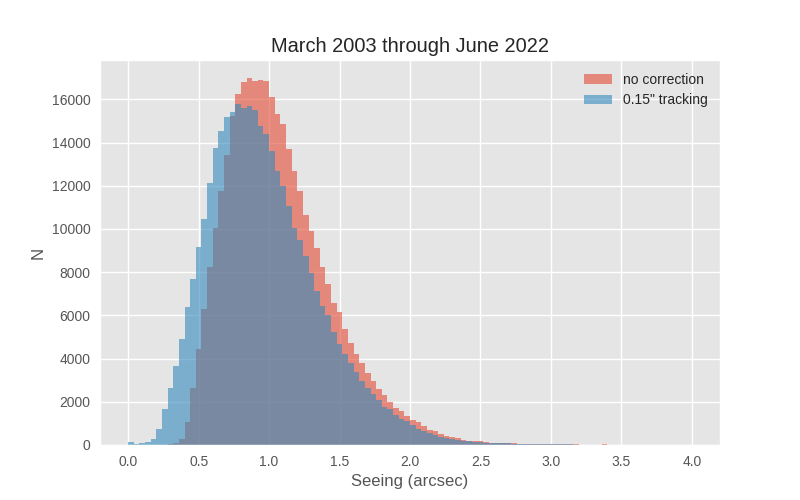

In [13]:
# make raw histogram of the zenith-corrected seeing column
#fixed.hist(column='seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    plt.hist(fixed['seeing'], bins=100, range=(0.0, 4.), alpha=0.6, label="no correction")
    plt.hist(fixed['seeing_corr'], bins=100, range=(0.0, 4.), alpha=0.6, label="0.15\" tracking")
    #plt.hist(fixed['seeing_corr20'], bins=100, range=(0.0, 4.), alpha=0.6, label="0.2\" tracking")
    #plt.hist(fixed['seeing_rawspot'], bins=100, range=(0.0, 4.), alpha=0.6, label="Spot FWHM")
    #plt.hist(fixed['seeing_spotfwhm'], bins=100, range=(0.0, 4.), alpha=0.6, label="Spot FWHM, 0.15\" tracking")
    plt.legend()
    plt.title("March 2003 through June 2022")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
plt.show()

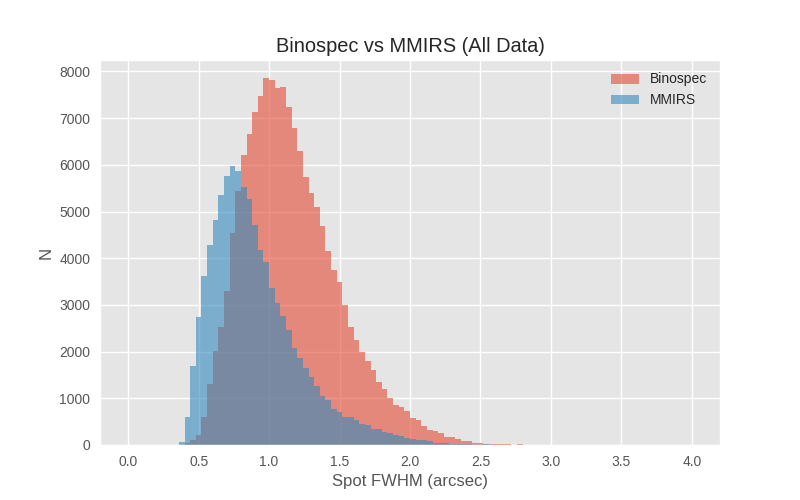

In [14]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    plt.hist(fixed['seeing'][fixed['wfs'] == 'binospec'], bins=100, range=(0.0, 4.), alpha=0.6, label="Binospec")
    plt.hist(fixed['seeing'][fixed['wfs'] == 'mmirs'], bins=100, range=(0.0, 4.), alpha=0.6, label="MMIRS")
    plt.legend()
    plt.title("Binospec vs MMIRS (All Data)")
    plt.xlabel("Spot FWHM (arcsec)")
    plt.ylabel("N")
plt.savefig("bino_vs_mmirs.pdf")
plt.show()

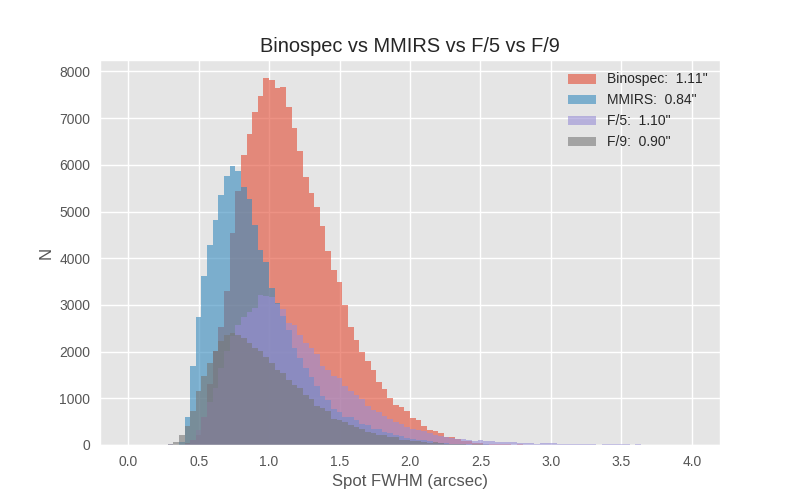

In [15]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    medb = np.median(fixed['seeing'][fixed['wfs'] == 'binospec'])
    medm = np.median(fixed['seeing'][fixed['wfs'] == 'mmirs'])
    med5 = np.median(fixed['seeing'][fixed['wfs'] == 'f5'])
    med9 = np.median(fixed['seeing'][(fixed['wfs'] == 'oldf9') | (fixed['wfs'] == 'newf9')])
    plt.hist(fixed['seeing'][fixed['wfs'] == 'binospec'], bins=100, range=(0.0, 4.), alpha=0.6, label=f"Binospec: {medb: .2f}\"")
    plt.hist(fixed['seeing'][fixed['wfs'] == 'mmirs'], bins=100, range=(0.0, 4.), alpha=0.6, label=f"MMIRS: {medm: .2f}\"")
    plt.hist(fixed['seeing'][fixed['wfs'] == 'f5'], bins=100, range=(0.0, 4.), alpha=0.6, label=f"F/5: {med5: .2f}\"")
    plt.hist(fixed['seeing'][(fixed['wfs'] == 'oldf9') | (fixed['wfs'] == 'newf9')], bins=100, range=(0.0, 4.), alpha=0.6, label=f"F/9: {med9: .2f}\"")
    plt.legend()
    plt.title("Binospec vs MMIRS vs F/5 vs F/9")
    plt.xlabel("Spot FWHM (arcsec)")
    plt.ylabel("N")
plt.savefig("bino_vs_mmirs_vs_f5_vs_f9.pdf")
plt.show()

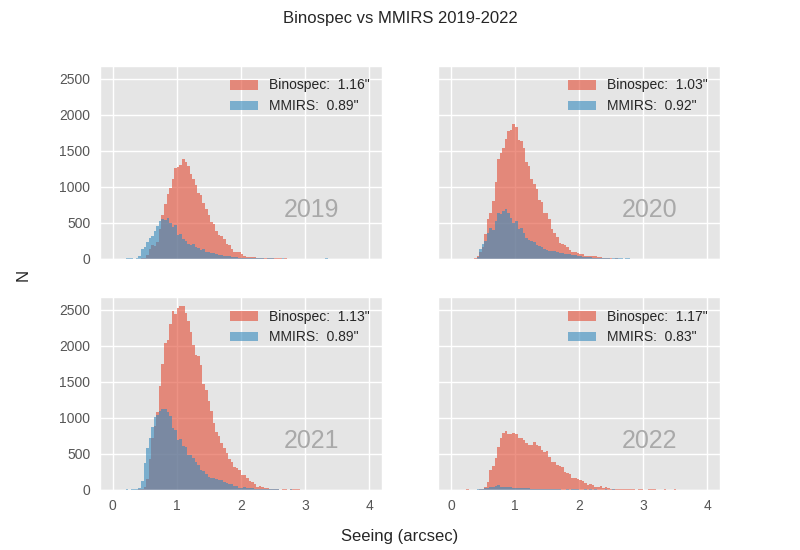

In [31]:
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.suptitle("Binospec vs MMIRS 2019-2022")
    fig.supylabel("N")
    fig.supxlabel("Seeing (arcsec)")
    years = [str(y) for y in range(2019, 2023)]
    for ((i, year), ax) in zip(enumerate(years), axs.flat):
        year_df = fixed.loc[year]
        medb = np.median(year_df['seeing'][year_df['wfs'] == 'binospec'])
        medm = np.median(year_df['seeing'][year_df['wfs'] == 'mmirs'])
        ax.hist(year_df['seeing'][year_df['wfs'] == 'binospec'], bins=100, range=(0.0, 4.), alpha=0.6, label=f"Binospec: {medb: .2f}\"")
        ax.hist(year_df['seeing'][year_df['wfs'] == 'mmirs'], bins=100, range=(0.0, 4.), alpha=0.6, label=f"MMIRS: {medm: .2f}\"")
        ax.annotate(
            year, 
            (0.75, 0.25),
            xycoords='axes fraction',
            ha='center',
            va='center',
            fontsize=18,
            color='darkgrey'
        )
        ax.legend()
plt.savefig("binospec_vs_mmirs_yearly.pdf")
plt.show()

In [32]:
fixed['seeing'][(fixed['wfs'] == 'oldf9') | (fixed['wfs'] == 'newf9')]

ut
2003-04-11 06:30:09    0.349903
2003-04-11 06:31:07    1.672037
2003-04-11 06:33:55    1.720327
2003-04-11 06:34:38    1.533618
2003-04-11 06:36:36    1.290397
                         ...   
2022-06-08 06:05:43    1.105345
2022-06-08 10:45:24    1.084042
2022-06-08 10:46:09    1.034348
2022-06-08 10:59:59    1.345923
2022-06-08 11:00:34    1.371194
Name: seeing, Length: 45672, dtype: float64

In [160]:
def wave_correct(seeing, obs_wave):
    refwave = 0.5
    wave_corr = refwave ** -0.2 / obs_wave ** -0.2
    return seeing * wave_corr

In [196]:
fixed['seeing_spot_airmass'] = fixed['seeing_rawspot'] / fixed['airmass']**0.6

In [197]:
fixed['seeing_spot_airmass'][fixed['wfs'] == 'binospec'].median(), fixed['seeing_spot_airmass'][fixed['wfs'] == 'mmirs'].median()

(0.832911113430903, 0.6788426227099141)

In [202]:
wave_correct(1.11, 0.55)

1.131361812905517

In [159]:
fixed['seeing_spot_airmass'][fixed['wfs'] == 'newf9'].median(), fixed['seeing_spot_airmass'][fixed['wfs'] == 'mmirs'].median()

(0.8942222144627104, 0.6788426227099141)

In [194]:
fixed['seeing'][fixed['wfs'] == 'binospec'].median(), fixed['seeing'][fixed['wfs'] == 'mmirs'].median()

(1.1115004461230096, 0.8327041994414974)

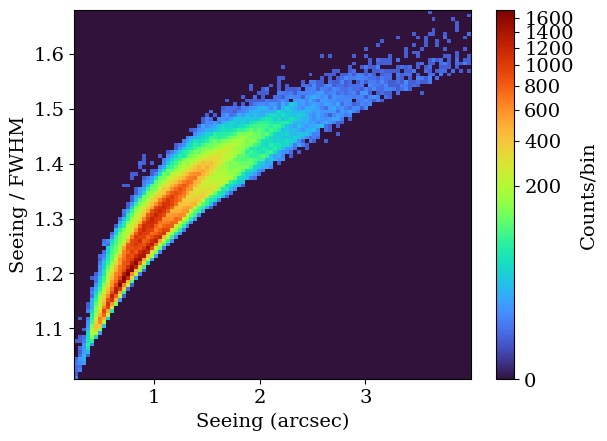

In [199]:
with plt.style.context('default'):
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    plt.hist2d(fixed['seeing'], fixed['seeing'] / fixed['seeing_spot_airmass'], bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Seeing / FWHM")
    cb = plt.colorbar()
    cb.set_label("Counts/bin")
    #plt.savefig("seeing_tempdiff.png")
    #plt.savefig("seeing_tempdiff.pdf")
    plt.show()

In [33]:
# fit a log-normal distribution to the seeing data
seeing = np.array(fixed['seeing'], dtype=float)
seeing = seeing[np.isfinite(seeing)]
sigma, loc, exp_mu = lognorm.fit(seeing)
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.median(seeing)
fit_median = exp_mu + loc

0.3627587290253035 0.05502607027293062 0.9569686323030171


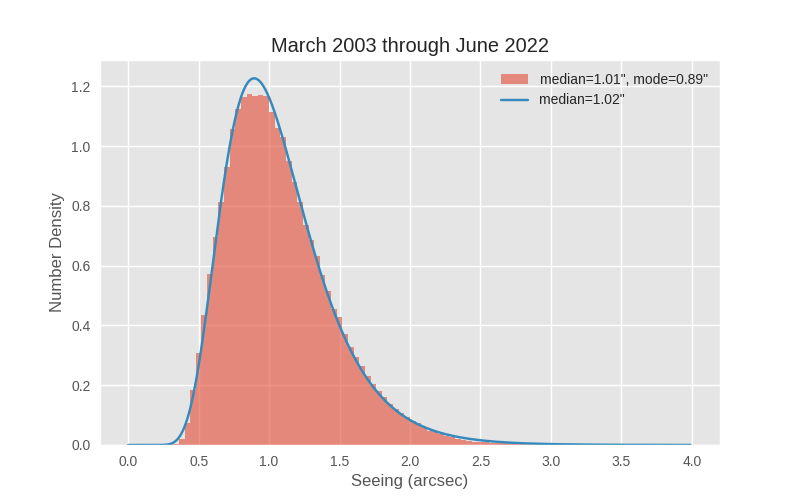

In [34]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(fixed['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title("March 2003 through June 2022")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig("all_hist.png")
    plt.savefig("all_hist.pdf")
plt.show()

In [35]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.nanmedian(first_half['seeing'])
med_2nd = np.nanmedian(second_half['seeing'])

/tmp/ipykernel_4138/1238025623.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8, 5))


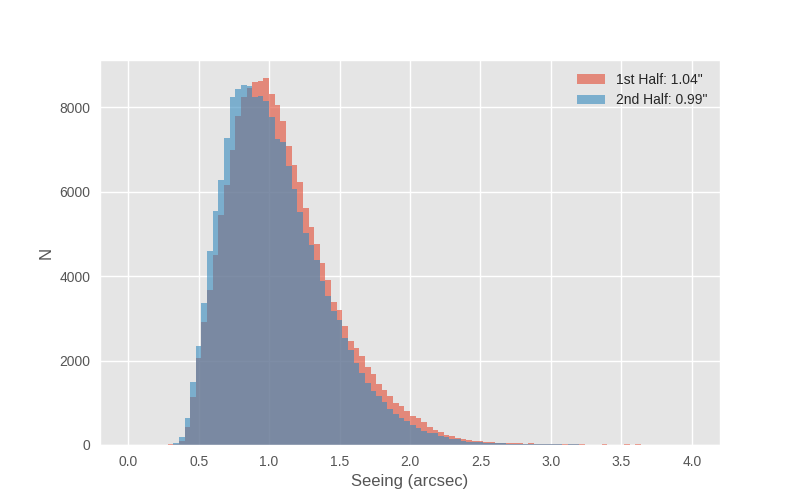

In [36]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("all_1st2nd.png")
plt.savefig("all_1st2nd.pdf")
plt.show()

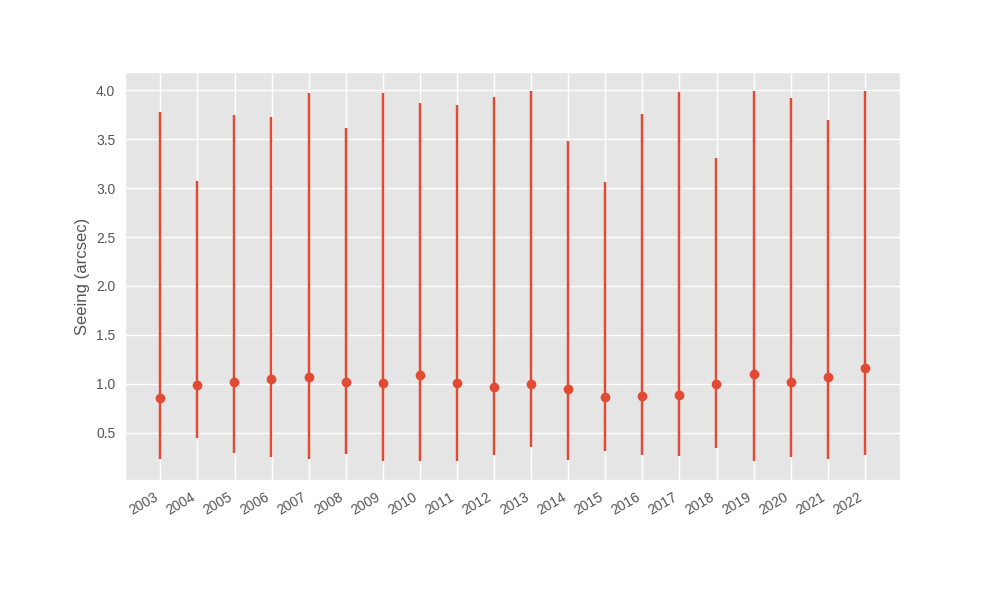

In [37]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots(figsize=(10, 6))
monthly = pd.DataFrame()
monthly['seeing'] = fixed.seeing.resample('Y', label='left').median()
monthly['max'] = fixed.seeing.resample('Y', label='left').max()
monthly['min'] = fixed.seeing.resample('Y', label='left').min()
lowb = monthly['seeing'] - monthly['min']
upb = monthly['max'] - monthly['seeing']
plt.errorbar(monthly.index, monthly['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.autofmt_xdate()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("all_nightly.png")
plt.savefig("all_nightly.pdf")
plt.show()

In [38]:
month_list = [str(y) for y in range(2003, 2023)]
data = [np.array(fixed.loc[month]['seeing']) for month in month_list]
clean_data = {}
for d, arr in zip(month_list, data):
    if len(arr) > 0:
        clean_data[d] = arr[np.isfinite(arr)]
month_labels = [datetime.strptime(d, "%Y").date() for d in clean_data.keys()]
sizes = [len(clean_data[y]) for y in clean_data]
month_list

['2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022']

In [39]:
first_meds = []
sec_meds = []
for y in clean_data:
    year = fixed.loc[y]
    first_half = year.between_time(start_time='00:00', end_time='07:00')
    second_half = year.between_time(start_time='07:00', end_time='14:00')
    med_1st = np.nanmedian(first_half['seeing'])
    med_2nd = np.nanmedian(second_half['seeing'])
    first_meds.append(med_1st)
    sec_meds.append(med_2nd)
    print(f"{y}: {med_1st:.2f} {med_2nd:.2f}")

2003: 0.90 0.83
2004: 0.97 1.02
2005: 1.11 0.95
2006: 1.03 1.08
2007: 1.11 1.02
2008: 1.02 1.01
2009: 0.98 1.02
2010: 1.11 1.06
2011: 1.03 0.98
2012: 0.97 0.96
2013: 1.08 0.88
2014: 0.99 0.90
2015: 0.92 0.82
2016: 0.93 0.84
2017: 0.91 0.87
2018: 1.01 0.99
2019: 1.10 1.10
2020: 1.05 0.98
2021: 1.10 1.05
2022: 1.16 1.16


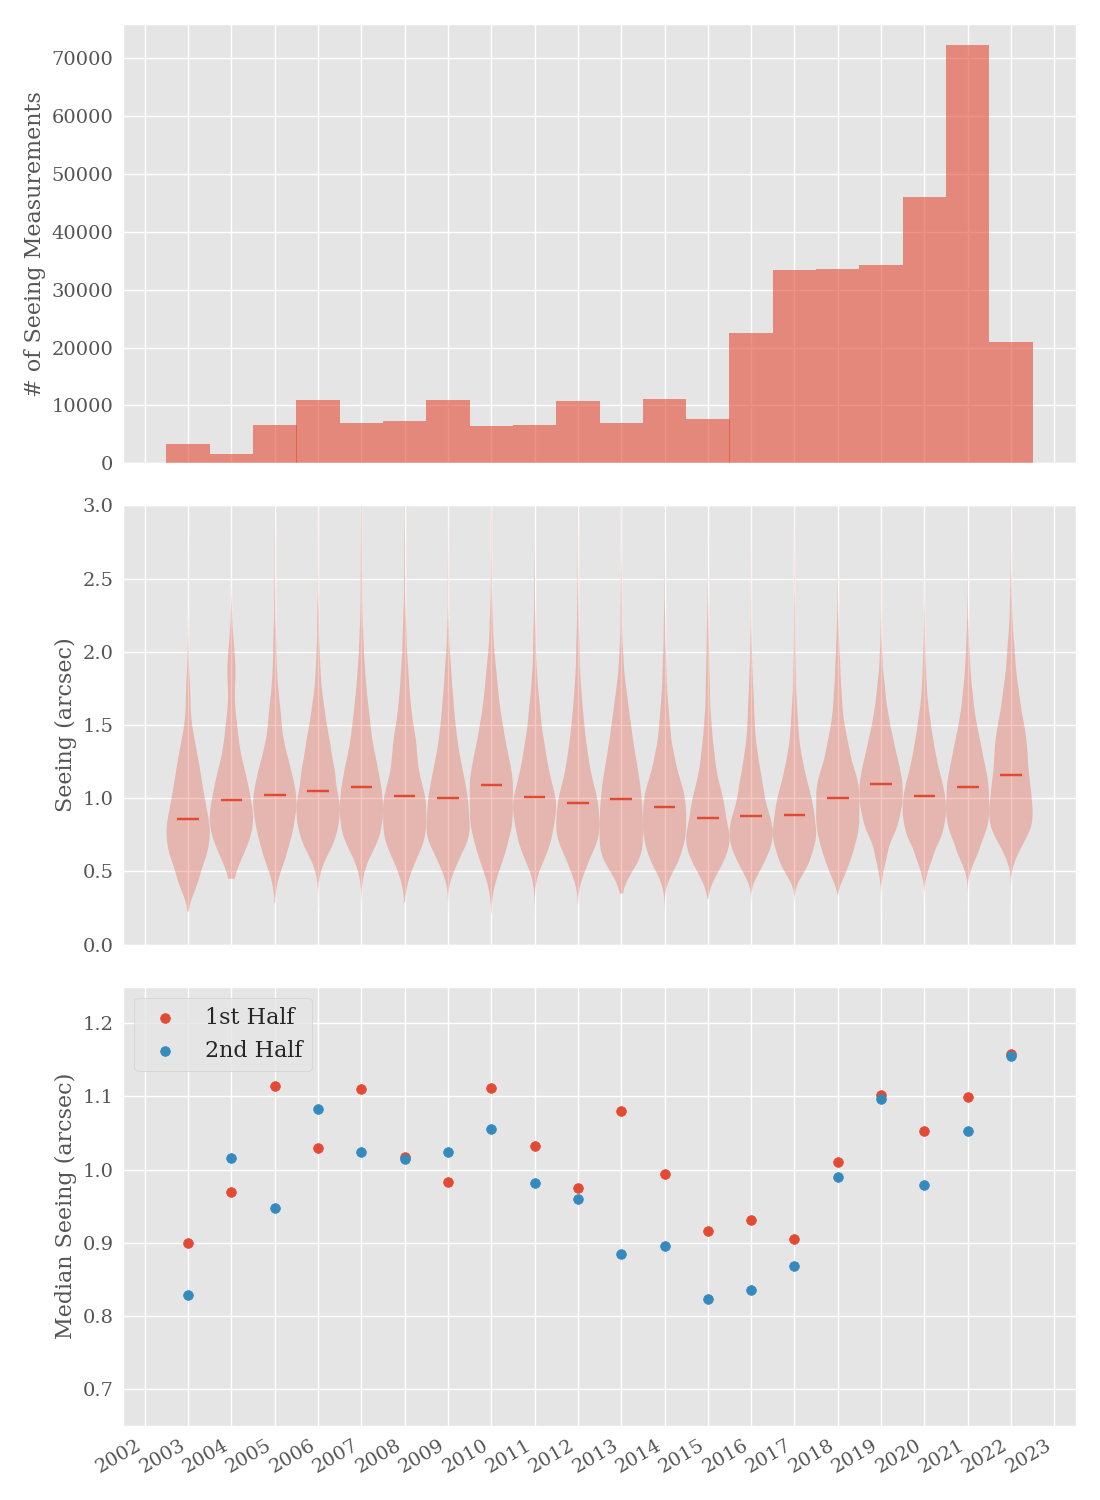

In [78]:
with plt.style.context('ggplot'):
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALLER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALLER_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
    fig, ax = plt.subplots(3, figsize=(11,15), sharex=True)
    ax[0].bar(mdates.date2num(month_labels), sizes, width=366, alpha=0.6)
    ax[0].set_ylabel("# of Seeing Measurements")
    ax[1].violinplot(clean_data.values(), mdates.date2num(month_labels), points=100, widths=365,
                showextrema=False, showmedians=True, bw_method='silverman')


    ax[1].set_ylim(0.0, 3.0)
    ax[1].set_ylabel("Seeing (arcsec)")
    ax[2].scatter(mdates.date2num(month_labels), first_meds, label="1st Half")
    ax[2].scatter(mdates.date2num(month_labels), sec_meds, label="2nd Half")
    ax[2].legend(frameon=True, fancybox=True)
    ax[2].set_ylim(0.65, 1.25)
    ax[2].set_ylabel("Median Seeing (arcsec)")
    ax[2].xaxis.set_major_locator(mdates.YearLocator())
    ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.savefig("all_violin.png")
    plt.savefig("all_violin.pdf")
    plt.show()

In [41]:
[len(clean_data[y]) for y in clean_data]

[3402,
 1672,
 6615,
 10946,
 6938,
 7249,
 11031,
 6503,
 6624,
 10730,
 6934,
 11143,
 7698,
 22586,
 33354,
 33672,
 34321,
 46049,
 72344,
 20926]

In [46]:
diff = fixed['osst'] - fixed['outt']
trim_seeing = fixed['seeing'][np.abs(diff) < 100]
diff = diff[np.abs(diff) < 100]

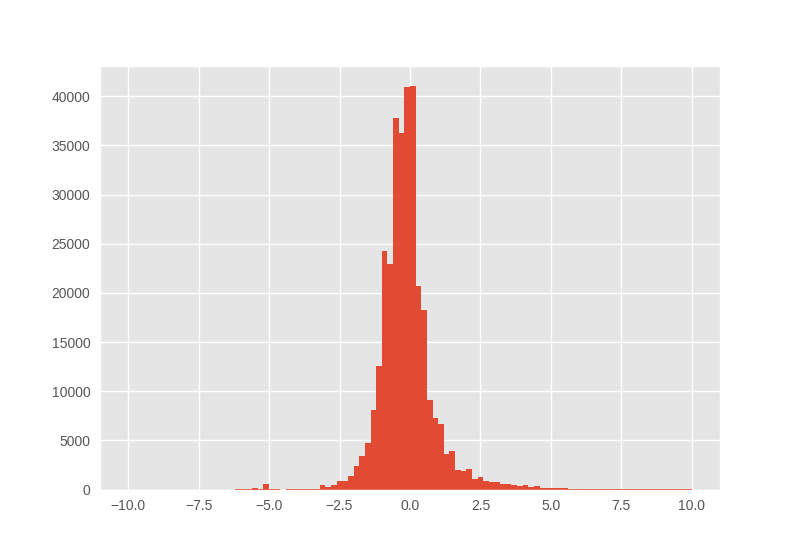

In [62]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots()
    ax.hist(diff, bins=100, range=(-10, 10))
plt.show()

In [63]:
temps = list(range(-3,6))
t_meds = []
for t in temps:
    seeing_slice = trim_seeing[(diff >= t-0.5) & (diff <= t+0.5)]
    t_meds.append(np.median(seeing_slice))
t_meds, temps

([1.1508015609756368,
  1.0150222204889983,
  0.9665987633337149,
  1.0035518755771768,
  1.1125912341808695,
  1.1500458509136038,
  1.278073700532242,
  1.3100613833642205,
  1.4545075405342371],
 [-3, -2, -1, 0, 1, 2, 3, 4, 5])

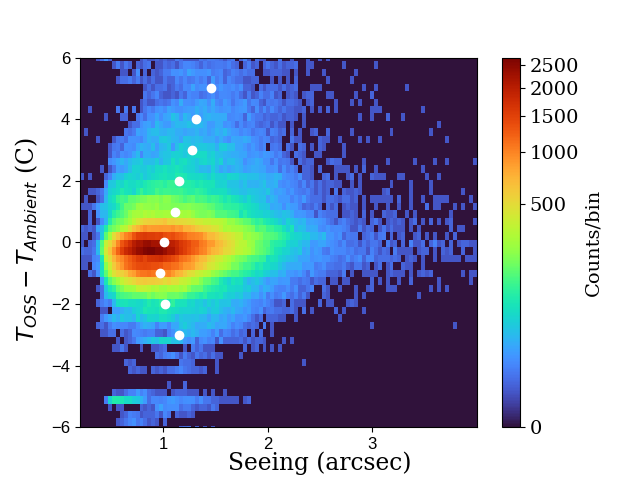

In [85]:
with plt.style.context('default'):
    fig, ax = plt.subplots()
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    h = ax.hist2d(trim_seeing, diff, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    fig.supxlabel("Seeing (arcsec)")
    fig.supylabel("$T_{OSS} - T_{Ambient}$ (C)")
    cb = fig.colorbar(h[-1])
    cb.set_label("Counts/bin")
    ax.set_ybound(-6, 6)
    ax.scatter(t_meds, temps, color='w')
    ax.tick_params(axis='both', labelsize=12)

plt.savefig("seeing_tempdiff.png")
plt.savefig("seeing_tempdiff.pdf")
plt.show()

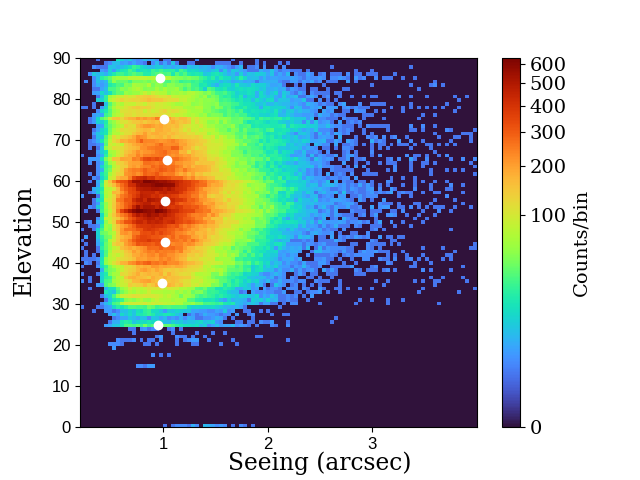

In [93]:
trimmed = fixed[np.isfinite(fixed['seeing'].astype(float)) & np.isfinite(fixed['el'].astype(float))]
trim_el = trimmed['el'].astype(float)
el_seeing = trimmed['seeing'].astype(float)
els = [25, 35, 45, 55, 65, 75, 85]
e_meds = []
for el in els:
    seeing_slice = el_seeing[(trim_el >= el-5) & (trim_el <= el+5)]
    e_meds.append(np.median(seeing_slice))
with plt.style.context('default'):
    fig, ax = plt.subplots()
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    h = ax.hist2d(el_seeing, trim_el, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    fig.supxlabel("Seeing (arcsec)")
    fig.supylabel("Elevation")
    cb = fig.colorbar(h[-1])
    cb.set_label("Counts/bin")
    plt.scatter(e_meds, els, color='w')
    ax.tick_params(axis='both', labelsize=12)

plt.savefig("seeing_elevation.png")
plt.savefig("seeing_elevation.pdf")
plt.show()

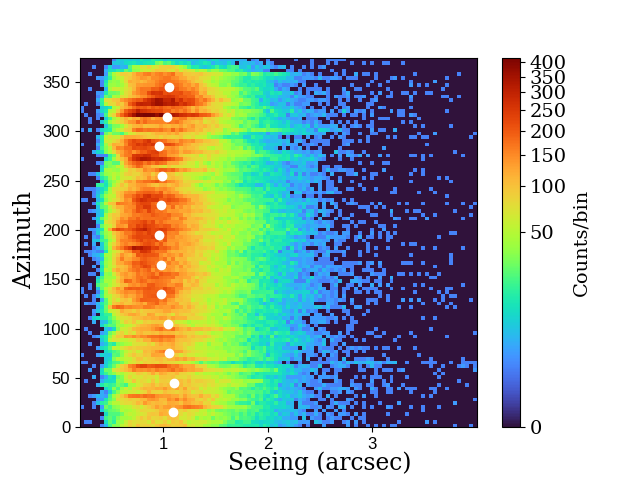

In [92]:
trimmed = fixed[np.isfinite(fixed['seeing'].astype(float)) & np.isfinite(fixed['az'].astype(float))]
trim_az = trimmed['az'].astype(float)
trim_az[trim_az < 0] += 360.
az_seeing = trimmed['seeing'].astype(float)
azs = [15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345]
a_meds = []
for az in azs:
    seeing_slice = az_seeing[(trim_az >= az-15) & (trim_az <= az+15)]
    a_meds.append(np.median(seeing_slice))
with plt.style.context('default'):
    fig, ax = plt.subplots()
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    h = ax.hist2d(az_seeing, trim_az, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    fig.supxlabel("Seeing (arcsec)")
    fig.supylabel("Azimuth")
    cb = fig.colorbar(h[-1])
    cb.set_label("Counts/bin")
    ax.scatter(a_meds, azs, color='w')
    ax.tick_params(axis='both', labelsize=12)

plt.savefig("seeing_azimuth.png")
plt.savefig("seeing_azimuth.pdf")
plt.show()

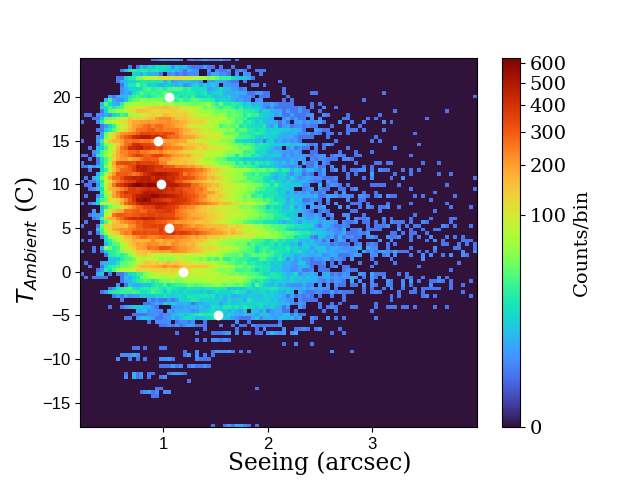

In [91]:
trimmed = fixed[np.isfinite(fixed['seeing'].astype(float)) & np.isfinite(fixed['outt'].astype(float))]
trim_outt = trimmed['outt'].astype(float)
outt_seeing = trimmed['seeing'].astype(float)
temps = list(range(-5, 25, 5))
temps_meds = []
for t in temps:
    seeing_slice = outt_seeing[(trim_outt >= t-2.5) & (trim_outt <= t+2.5)]
    temps_meds.append(np.median(seeing_slice))
with plt.style.context('default'):
    fig, ax = plt.subplots()
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    h = ax.hist2d(outt_seeing, trim_outt, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    fig.supxlabel("Seeing (arcsec)")
    fig.supylabel("$T_{Ambient}$ (C)")
    cb = fig.colorbar(h[-1])
    cb.set_label("Counts/bin")
    ax.scatter(temps_meds, temps, color='w')
    ax.tick_params(axis='both', labelsize=12)
    
plt.savefig("seeing_ambient.pdf")
plt.savefig("seeing_ambient.png")
plt.show()

In [36]:
fixed.columns

Index(['time', 'wfs', 'file', 'exptime', 'airmass', 'az', 'el', 'osst', 'outt',
       'chamt', 'tiltx', 'tilty', 'transx', 'transy', 'focus', 'focerr',
       'cc_x_err', 'cc_y_err', 'xcen', 'ycen', 'seeing', 'raw_seeing', 'fwhm',
       'wavefront_rms', 'residual_rms'],
      dtype='object')

In [50]:
fixed.to_csv("all_seeing.csv")

In [59]:
plt.close('all')

In [96]:
june_2022 = fixed.loc['06-08-2022':'06-27-2022']

In [97]:
june_2022

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,ycen,seeing,raw_seeing,fwhm,wavefront_rms,residual_rms,seeing_corr,seeing_corr20,seeing_spotfwhm,seeing_rawspot
ut,,,,,,,,,,,,,,,,,,,,,
2022-06-08 03:30:14.000,2022-06-08T03:30:14,newf9,f9wfs_20220607-203018.fits,5.0,1.0593,97.642308,70.730236,19,19.3,18.933,...,411.999789,0.884051,0.915142,8.30266,3988.752806,1508.413348,0.762409,0.658010,0.669013,0.755413
2022-06-08 03:30:39.000,2022-06-08T03:30:39,newf9,f9wfs_20220607-203042.fits,10.0,1.0588,97.730414,70.819017,19,19.3,18.984,...,410.999941,0.877570,0.908176,8.255724,3800.858991,1461.867543,0.755190,0.649988,0.663762,0.750618
2022-06-08 03:31:29.000,2022-06-08T03:31:29,newf9,f9wfs_20220607-203133.fits,15.0,1.0577,97.9048,70.99305,19,19.3,19.032,...,406.666489,1.102875,1.140627,9.806904,1595.572022,1436.668333,0.999376,0.913654,0.838400,0.907605
2022-06-08 03:32:24.000,2022-06-08T03:32:24,newf9,f9wfs_20220607-203226.fits,19.0,1.0564,98.103273,71.188336,19,19.3,19.061,...,411.333575,1.076013,1.112025,9.617748,633.570478,1418.806063,0.970514,0.882853,0.818274,0.888600
2022-06-08 03:33:09.000,2022-06-08T03:33:09,newf9,f9wfs_20220607-203312.fits,19.0,1.0555,98.264141,71.344537,19,19.3,19.082,...,404.666762,0.993333,1.026053,9.046272,687.176555,1332.730801,0.881383,0.787284,0.755216,0.830970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-23 08:04:02.914,2022-06-23T08:04:02.914000,f5,f5wfs_20220623-010435.fits,30.0,1.4426,189.483932,43.882741,17,15.2,16.461,...,265.004357,1.522649,1.897088,10.299734,439.772679,1534.699924,1.460394,1.410723,1.095394,1.362480
2022-06-23 08:04:40.136,2022-06-23T08:04:40.136000,f5,f5wfs_20220623-010512.fits,30.0,1.4431,189.68042,43.862624,17,15.2,16.492,...,264.008047,1.160155,1.445752,8.306116,343.276099,1418.612068,1.084937,1.023942,0.855069,1.086431
2022-06-23 08:05:43.820,2022-06-23T08:05:43.820000,f5,f5wfs_20220623-010616.fits,30.0,1.4441,190.039343,43.824655,17,15.2,16.513,...,264.003591,1.223723,1.525603,8.663853,274.681395,1454.631891,1.151325,1.092848,0.898391,1.136209


In [98]:
np.median(june_2022['seeing'])

0.9925723588924057

In [99]:
from minicyclop.io import read_seeing_data
cyc = read_seeing_data(Path.home() / "MMT/minicyclop/data/MiniCyclop/Data/Seeing_Data.txt")

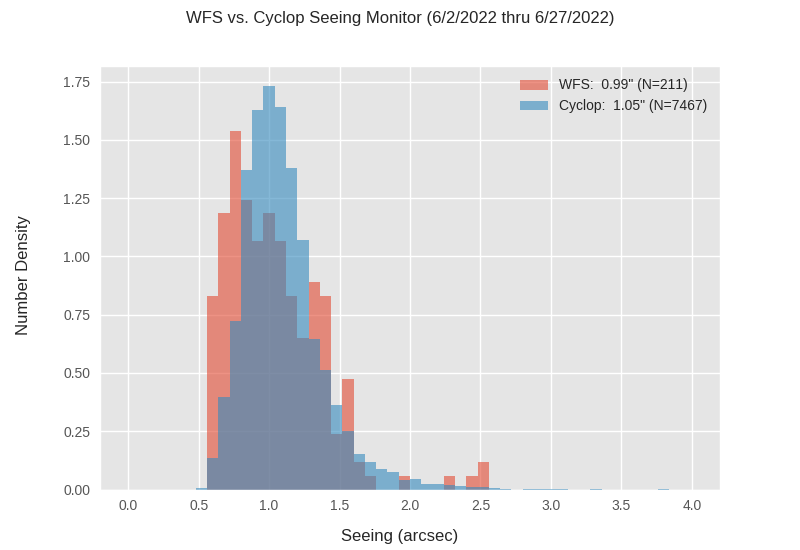

In [112]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots()
    med_wfs = np.median(june_2022['seeing'])
    med_cyc = np.median(cyc['seeing'])
    w = ax.hist(june_2022['seeing'], density=True, bins=50, range=(0.0, 4.0), label=f"WFS: {med_wfs: .2f}\" (N={len(june_2022)})", alpha=0.6)
    c = ax.hist(cyc['seeing'], density=True, bins=50, range=(0.0, 4.0), label=f"Cyclop: {med_cyc: .2f}\" (N={len(cyc)})", alpha=0.6)
    fig.supxlabel("Seeing (arcsec)")
    fig.supylabel("Number Density")
    fig.suptitle("WFS vs. Cyclop Seeing Monitor (6/2/2022 thru 6/27/2022)")
    ax.legend()
plt.savefig("wfs_cyclop.pdf")
plt.savefig("wfs_cyclop.png")
plt.show()